In [5]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import cv2
import scipy.io
import pandas as pd
import emcee as mc
import scipy.optimize as op
import corner

## Janine Birnbaum 

Created June 28, 2019

Last update July 31, 2019

Read flow data from video files and still images and compare with model.

In [6]:
# Shortcut functions for trigonometric functions in degrees

def sind(theta):
    """Calculate sine of theta in degrees.
    
    :Input:
     - *theta* (array_like) - Angle in degrees.
     
     :Output:
     - (array_like) - Sine value.
    
    """
    
    return np.sin(np.deg2rad(theta))

def cosd(theta):
    """Calculate cosine of theta in degrees.
    
    :Input:
     - *theta* (array_like) - Angle in degrees.
     
     :Output:
     - (array_like) - Cosine value.
    
    """
    
    return np.cos(np.deg2rad(theta))

def tand(theta):
    """Calculate cosine of theta in degrees.
    
    :Input:
     - *theta* (array_like) - Angle in degrees.
     
     :Output:
     - (array_like) - Cosine value.
    
    """
    
    return np.tan(np.deg2rad(theta))

## Flow of a Herschel-Bulkley fluid on an inclined plane following derivation from Liu & Mei (1989), Balmforth et al. (2007):

$ \frac{\partial h}{\partial t} = -\left( \frac{\rho g}{K} \right)^{1/n} \frac{\partial}{\partial x} \left[ \frac{n \left| \sin{\theta} - \cos{\theta} \frac{\partial h}{\partial x} \right|^{1/n-1} Y^{1+1/n}}{(n+1)(2n+1)} \left[(1+2n)h-nY \right] \left( \sin{\theta} -  \cos{\theta} \frac{\partial h}{\partial x} \right) \right] $

$ Y = h - \frac{\tau_y}{\rho g |\sin{\theta} -\cos{\theta} \frac{\partial h}{\partial x}|} $

For full derivation see included PDF "Viscoplastic Flow Derivation".

In [7]:
def damBreak(x, h0, theta, rho, K, tauy, n, g, ts, i):
    
    """Solve flow for a Herschel-Bulkley fluid with 2-step Runge-Kutta 
    in time, centered in space for on an inclined surface.
    
    :Input:
     - *x*     (ndarray(m+2))      - Evaluation points in x [m].
     - *h0*    (ndarray(m+2))      - Initial height at evaluation points in x [m].
     - *theta* (float)             - Slope [deg].
     - *rho*   (float)             - Fluid density [kg/m^3].
     - *K*     (float)             - Fluid consistency [Pa s].     
     - *tauy*  (float)             - Yield stress [Pa].
     - *n*     (float)             - Rheology power law exponent.
     - *g*     (float)             - Gravitational constant [m/s^2].
     - *ts*    (float)             - Final time for simulation [sec].
     - *i*     (int)               - Number of points for discretization in t.
     

    :Output:
     - (ndarray(m+2, i+2)) - Solution of ODE.
     - (ndarray(i+2)) - Evaluation times.
    """

    # Discretize domain 
    dx = x[1:] - x[:-1]
    dt = ts/(i+1)
    t = np.linspace(0, ts, i+2)

    # Initialize solution
    h = np.zeros((i+2,x.size))    
    h[0,:] = h0
    
    # Solve
    for k in np.arange(i+1):
        
        for j, s in enumerate([0.5, 1]):
            
            hr = (h[k+j,2:] + h[k+j,1:-1])/2
            hl = (h[k+j,1:-1] + h[k+j,:-2])/2
            hxr = sind(theta) - cosd(theta)*(h[k+j,2:] - h[k+j,1:-1])/dx[1:]
            hxl = sind(theta) - cosd(theta)*(h[k+j,1:-1] - h[k+j,:-2])/dx[:-1]
            Yr  = hr - tauy/(rho*g*np.abs(hxr))
            Yl  = hl - tauy/(rho*g*np.abs(hxl))
        
            Yr[Yr<0] = 0
            Yl[Yl<0] = 0
        
            Qr = n*((np.abs(hxr))**(1/n-1)*(Yr)**(1+1/n))/((n+1)*(2*n+1))*((1+2*n)*hr - n*Yr)*hxr
            Ql = n*((np.abs(hxl))**(1/n-1)*(Yl)**(1+1/n))/((n+1)*(2*n+1))*((1+2*n)*hl - n*Yl)*hxl
        
            Qr[hxr==0] = 0
            Ql[hxl==0] = 0
    
            h[k+1,1:-1] = h[k,1:-1] - s*dt/dx[:-1]*(rho*g/K)**(1/n)*(Qr - Ql)
            
            # Boundary conditions
            h[k+1,0] = h[k+1,1]
    
    return h, t

## Comparison to experimental data

Import video of experimental data and find the flow front through time:

In [20]:
# Change these parameters

startFrame = 0
endFrame = 750

# RGB channel and threshold for front picking
thresh = 150
channel = 2 #0 = Red, 1 = Green, 2 = Blue

# Video file
filedir = '' # path to file
filename = 'MVI_0680_short.avi'# file name

# manually set starting location, line for analysis
# black in next figure
x0 = 468 # pixels
yline = 1200

# crop image
top = 900
bottom = 1500

title_str = 'Experiment Name'
L = 0.2 # reservoir length in m
H = 0.05 # fluid height in reservoir in m
rho = 1400 # fluid density in kg/m^3
theta = 0 # slope in degrees
K_fluid = 8 # syrup viscosity in Pas
T = 25 # temperature in deg C

In [ ]:
def Visc(T): 
    """Calculate viscosity of 77% sugar corn syrup at specified Temperature based on 
    best-fit curve calibrated between 23.5 - 46 deg C.
    
    :Input:
     - *T* (array_like)      - Evaluation temperatures in [deg C].
     
    :Output:
     - (array_like)          - Viscosity at temperatures T in [Pa s].

    """
    return 15603*T**(-2.44)

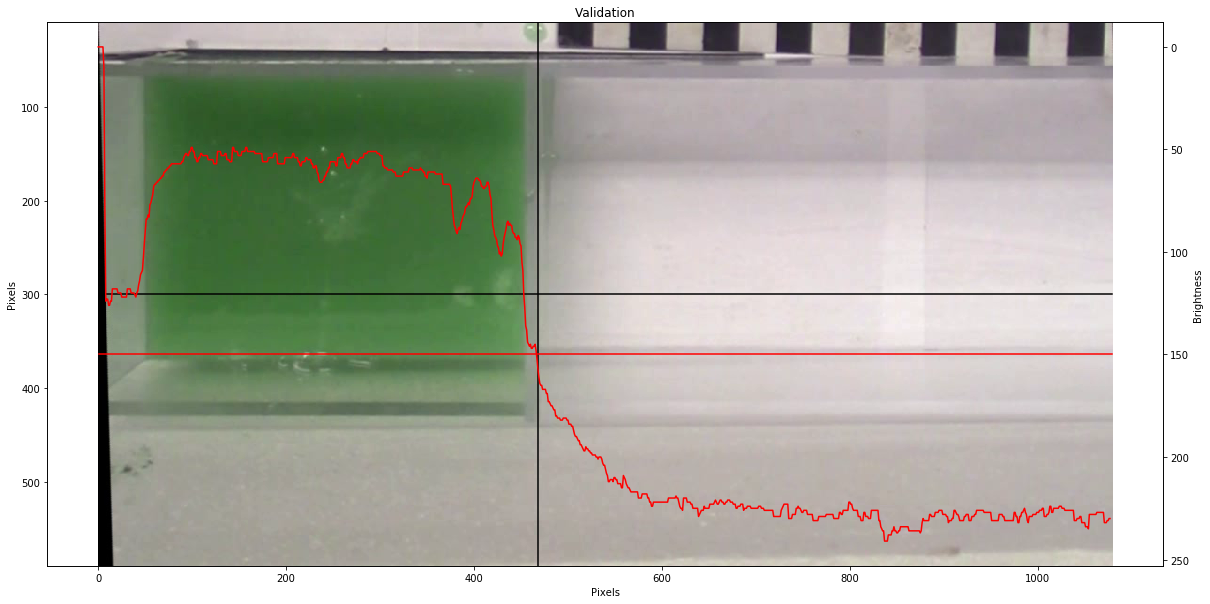

In [187]:
y2 = bottom - top - 1

# read first frame from video
cap = cv2.VideoCapture(filedir +  filename)
fps = cap.get(cv2.CAP_PROP_FPS)

ret, frame = cap.read()
if ret:
    pic = np.flip(frame,2)
    pic = np.transpose(pic,axes=(1,0,2)) #turn on for flow from top to bottom
cap.release()

# plot cropped image, profile for analysis
# x0 and yline in black
# threshold and profile along yline in red
fig,ax = plt.subplots(figsize=(20,10))
ax.imshow(pic[top:bottom,:,:])
ax.plot([x0, x0], [0, y2], 'k')
ax.plot([1, pic.shape[1]-1], [yline-top, yline-top], 'k')
ax2 = ax.twinx() 
ax2.plot(pic[yline,1:-1,channel], 'r')
ax2.plot([1, pic.shape[1]-1], [thresh, thresh], 'r')
ax2.invert_yaxis()
ax.set_xlabel('Pixels')
ax.set_ylabel('Pixels')
ax2.set_ylabel('Brightness')
ax.set_title(title_str);

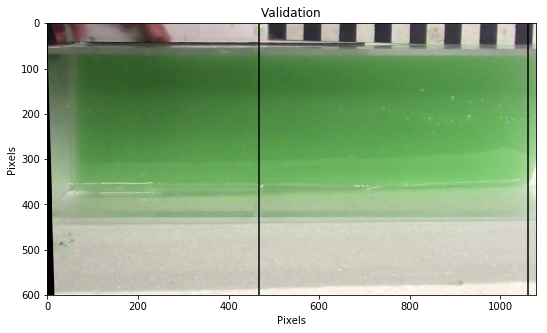

In [188]:
currentFrame = 0

y2 = bottom - top - 1

# read video from start to end frame
cap = cv2.VideoCapture(filedir +  filename)
fps = cap.get(cv2.CAP_PROP_FPS)
pos = np.zeros(endFrame-startFrame)

while(currentFrame<endFrame):
    ret, frame = cap.read()
    if currentFrame >= startFrame:
        if ret:
            pic = np.flip(frame,2)
            pic = np.transpose(pic,axes=(1,0,2)) #turn on for flow from top to bottom
            pos[currentFrame - startFrame] = np.max(np.where(pic[yline,:,channel]<thresh))
    
    currentFrame += 1
    
cap.release()

# plot final frame
fig,ax = plt.subplots(figsize=(15,5))
ax.imshow(pic[top:bottom,:,:])
ax.plot([x0, x0], [0, y2], 'k')
ax.plot([pos[-1], pos[-1]], [0, y2], 'k')
ax.set_xlabel('Pixels')
ax.set_ylabel('Pixels')
ax.set_title(title_str);

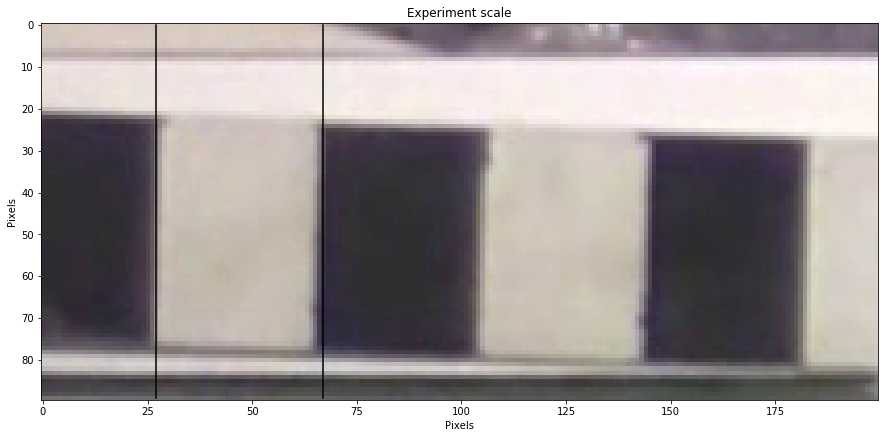

In [11]:
# Calculate image scale
# Crop image
top2 = 860
bottom2 = 950
left2 = 500
right2 = 700

# Plot
fig,ax = plt.subplots(figsize=(15,20))
ax.imshow(pic[top2:bottom2,left2:right2,:])

# Set to align with one 2cm segment on scale
lft = 27
rgt = 67

# Plot
ax.plot([lft, lft], [0, bottom2-top2-1], 'k')
ax.plot([rgt, rgt], [0, bottom2-top2-1], 'k')

# Determine scaling factors
W = 0.02 # m
k = W/(rgt-lft) # m/pixel
ax.set_xlabel('Pixels')
ax.set_ylabel('Pixels')
ax.set_title('Experiment scale');

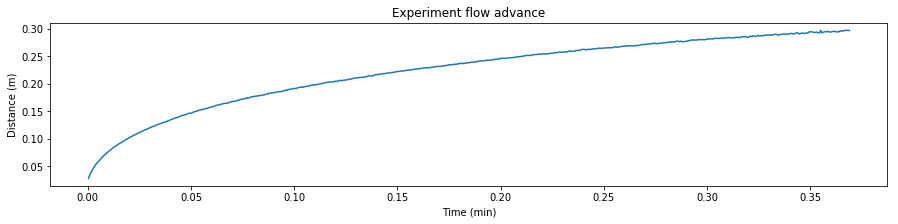

In [21]:
# scale time and front position
pos_scaled = (pos-x0)*k
pos_scaled[pos_scaled<0] = 0
t_scaled = np.arange((pos_scaled).size)/fps

t0 = 2.85 # Time of dam release [sec]

pos_scaled = pos_scaled[t_scaled>t0]
t_scaled = t_scaled[t_scaled>t0]-t0

# plot scaled front advance
fig,ax = plt.subplots(figsize=(15,3))
ax.plot(t_scaled/60, pos_scaled)
ax.set_xlabel('Time (min)')
ax.set_ylabel('Distance (m)')
ax.set_title('Experiment flow advance');

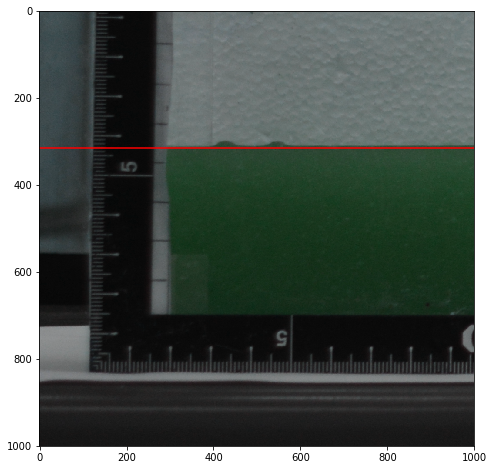

In [14]:
# Change these parameters
filedir = r'C:\Users\Janine\Documents\Columbia Research\3-phase_flow\Lab_Photos\77sugar\Particle-syrup validation\566D5200'# path to file
filename = '\DSC_0097.JPG'# file name of side photo

# Crop image
top = 2000
bottom = 3000

left = 500
right = 1500

base = 1.27 # channel base thickness in cm

# Load and plot
img = cv2.imread(filedir + filename) 

fig, ax = plt.subplots(figsize=(12,8))
plt.imshow(img[top:bottom, left:right])

# Find top of reservoir
height = 315
plt.plot([0, right-left-1], [height, height],'r')

# Reservoir depth
H = (5.7 - base)/100 # in m

In [133]:
# Save data to file

df = pd.DataFrame({'X_pos':pos_scaled, 'Time':t_scaled})
meta = pd.DataFrame({'H':H, 'L':L, 'K_fluid':K_fluid, 'Rho':rho, 'Slope':theta, 'Title':title_str, 'Temp':T}, index=[0])

df.to_hdf(title_str + '.h5', key='df', mode='w')
meta.to_hdf(title_str + '.h5', key='meta', mode='a')

In [23]:
# Setup model for MCMC

def lnlike(mu, x, y, yerr):
    K, tauy, n = mu
    h, t = damBreak(x_grid, h0, 0, 1540, K, tauy, n, 9.81, t_scaled[-1], 25*t_scaled.shape[0])
    X = np.zeros_like(t_scaled)

    threshold = 0.0001
    for j in np.arange(t_scaled.shape[0]):
        X[j] = x_grid[np.max(np.nonzero(h[j*25,:]>threshold)) + 1] # find node with h>threshold

    model = X
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [26]:
# Initial guesses for MCMC
K_init = 20
K_min = 8
K_max = 25

tauy_init = 0.1
tauy_min = 0
tauy_max = 0.5

n_init = 1
n_min = 0.8
n_max = 3

init_pos = [K_init, tauy_init, n_init]

# load data to MCMC
x = t_scaled
y = pos_scaled + L

# Define model resolution for MCMC
x_grid = np.linspace(0,0.75,26)
dx = x[1] - x[0]
yerr = 2*dx
h0 = np.zeros_like(x_grid)
h0[x_grid<0.2] = H

In [27]:
# Uniform prior distribution
def lnprior(mu):
    K, tauy, n = mu
    if K_min < K < K_max and tauy_min < tauy < tauy_max and n_min < n < n_max:
        return 0.0
    return -np.inf

def lnprob(mu, x, y, yerr):
    lp = lnprior(mu)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(mu, x, y, yerr)

In [61]:
# Create walkers
ndim, nwalkers = 3, 100
mu_pos = [init_pos + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]

In [62]:
# Run MCMC
sampler = mc.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))
sampler.run_mcmc(mu_pos, 500);

C:\Users\Janine\Anaconda3\lib\site-packages\emcee\ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
C:\Users\Janine\Anaconda3\lib\site-packages\emcee\ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


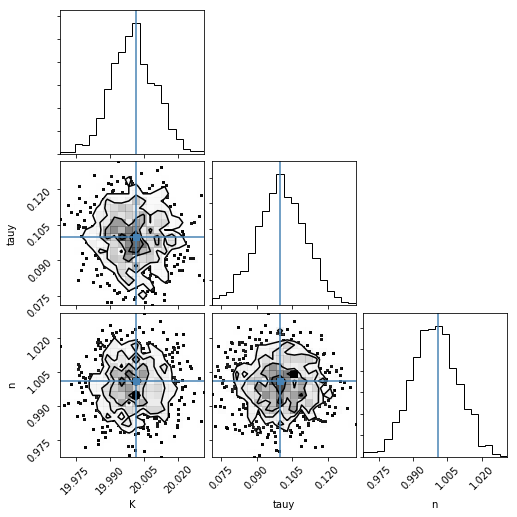

In [63]:
# Inspect MCMC results
samples = sampler.chain[:, :, :].reshape((-1, ndim))

s = 20 # ignore initial samples
K_fit = samples[s:,0]; tauy_fit = samples[s:,1]; n_fit = samples[s:,2]

# Find mode of each posterior distribution
N, bin_edges = np.histogram(K_fit, bins=20)
K_post = np.mean([bin_edges[np.argmax(N)], bin_edges[np.argmax(N)+1]]) 
N, bin_edges = np.histogram(tauy_fit, bins=20)
tauy_post = np.mean([bin_edges[np.argmax(N)], bin_edges[np.argmax(N)+1]]) 
N, bin_edges = np.histogram(n_fit, bins=20)
n_post = np.mean([bin_edges[np.argmax(N)], bin_edges[np.argmax(N)+1]]) 

# plot
fig = corner.corner(samples, labels=["K", "tauy", "n"],
                   truths=[K_post, tauy_post, n_post])

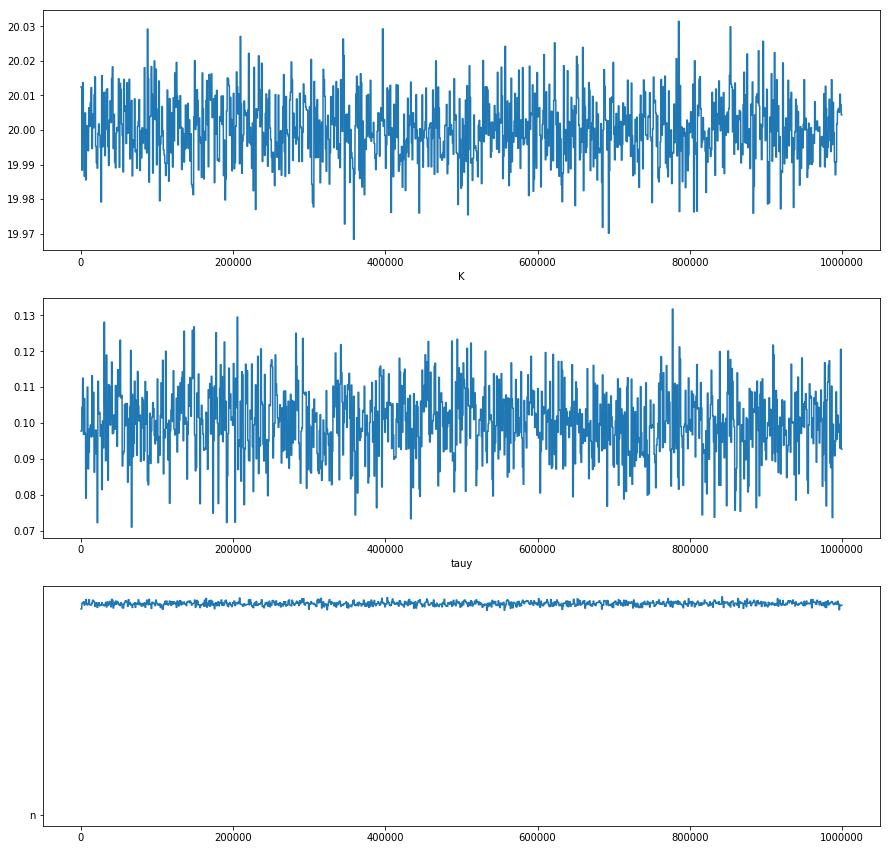

In [64]:
# inspect runs
fig,ax = plt.subplots(nrows=3, figsize=(15,15))
ax[0].plot(samples[:,0])
ax[0].set_xlabel('K')
ax[1].plot(samples[:,1])
ax[1].set_xlabel('tauy')
ax[2].plot(samples[:,2])
ax[2].plot('n');

C:\Users\Janine\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Janine\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Janine\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in power
C:\Users\Janine\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in multiply
C:\Users\Janine\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in power
C:\Users\Janine\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in multiply


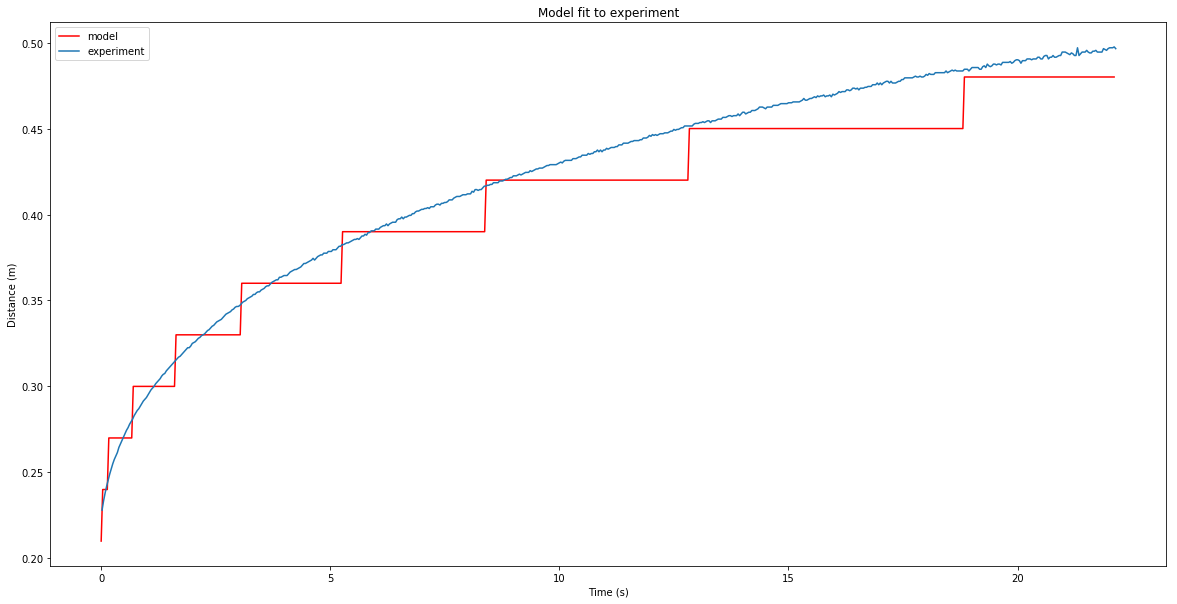

In [65]:
# Plot most probable model with data

h, t = damBreak(x_grid, h0, 0, 1540, K_post, tauy_post, n_post, 9.81, np.max(t_scaled), 25*t_scaled.shape[0])
X = np.zeros_like(t_scaled)
t_match = np.zeros_like(t_scaled)

threshold = 0.0001
for j in np.arange(t_scaled.shape[0]):
    X[j] = x_grid[np.max(np.nonzero(h[j*25,:]>threshold)) + 1] # find node with h>threshold
    t_match[j] = t[j*25]

# Plot front advance
fig,ax = plt.subplots(figsize=(20,10))

ax.plot(t_match,X,'r-',label='model');
ax.plot(t_scaled,pos_scaled+L,label='experiment')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Distance (m)')
ax.set_title('Model fit to experiment')
ax.legend();

In [134]:
# Save posterior distribution

meta['K_post'] = K_post
meta['tauy_post'] = tauy_post
meta['n_post'] = n_post

meta.to_hdf(title_str + '.h5', key='meta', mode='a')